# Impedance Matching

A generator with an internal impedance $Z_S$ delivers a power to a passive load $Z_L$, through a 2-ports matching network.

This problem is commonly named as "the double matching problem". Impedance matching is important for the following reasons:

 - Maximizing the power transfer.
   - Maximum power is delivered to the load when the generator _and_ the load are matched to the line and power loss in the line minimized
 - Improving signal-to-noise ratio of the system
 - Reducing amplitude and phase errors
 - Reducing reflected power toward generator
 
<img src="figures/Impedance_matching_general.svg">

As long as the load impedance $Z_L$ has a real positive part, a matching network can always be found. Many choices are available and the examples below only describe a few. The examples are taken from the D.Pozar book "Microwave Engineering", 4th edition. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf

## Matching with Lumped Elements
To begin, let's assume that the matching network is lossless and the feeding line characteristic impedance is $Z_0$:  

<img src="figures/Impedance_matching_lumped1.svg">

The simplest type of matching network is the "L" network (two reactive elements). 

2 possible configurations exist:

<img src="figures/Impedance_matching_lumped2.svg">
<img src="figures/Impedance_matching_lumped3.svg">

Let's assume the load is $Z_L = 200 - 100j \Omega$ for a line $Z_0=100\Omega$ at the frequency of 500 MHz. 

In [3]:
Z_L = 200 - 100j
Z_0 = 100
f_0_str = '500MHz'

Let's define the `Frequency` and load `Network`:

In [4]:
# frequency band centered on the frequency of interest
frequency = rf.Frequency(start=300, stop=700, npoints=401, unit='MHz')
# transmission line Media
line = rf.DefinedGammaZ0(frequency=frequency, z0=Z_0)
# load Network
load = line.load(rf.zl_2_Gamma0(Z_0, Z_L))

We are searching for a L-C Network corresponding to the first configuration above:
<img src="figures/Impedance_matching_lumped4.svg">

In [5]:
def matching_network_LC_1(L, C):
    ' L and C in nH and pF'
    return line.inductor(L*1e-9)**line.shunt_capacitor(C*1e-12)**load

def matching_network_LC_2(L, C):
    ' L and C in nH and pF'
    return line.capacitor(C*1e-12)**line.shunt_inductor(L*1e-9)**load

Finding the set of inductance $L$ and the capacitance $C$ which matches the load is an optimization problem. The `scipy` package provides the necessary optimization function(s) for that:

In [6]:
from scipy.optimize import minimize

# initial guess values
L0 = 10 # nH
C0 = 1 # pF
x0 = (L0, C0)
# bounds
L_minmax = (1, 100) # nH
C_minmax = (0.1, 10) # pF

# the objective functions minimize the return loss at the target frequency f_0
def optim_fun_1(x, f0=f_0_str):
    _ntw = matching_network_LC_1(*x)
    return np.abs(_ntw[f_0_str].s).ravel()

def optim_fun_2(x, f0=f_0_str):
    _ntw = matching_network_LC_2(*x)
    return np.abs(_ntw[f_0_str].s).ravel()

In [7]:
res1 = minimize(optim_fun_1, x0, bounds=(L_minmax, C_minmax))
print(f'Optimum found for LC network 1: L={res1.x[0]} nH and C={res1.x[1]} pF')

Optimum found for LC network 1: L=38.984840155695906 nH and C=0.922773823720536 pF


In [8]:
res2 = minimize(optim_fun_2, x0, bounds=(L_minmax, C_minmax))
print(f'Optimum found for LC network 2: L={res2.x[0]} nH and C={res2.x[1]} pF')

Optimum found for LC network 2: L=46.13869161616673 nH and C=2.5989893367481716 pF


Now that the optimum solutions have been found, let's plot the return loss for both cases:

In [9]:
ntw1 = matching_network_LC_1(*res1.x)
ntw2 = matching_network_LC_2(*res2.x)

(1.0, 6.637033373316683)

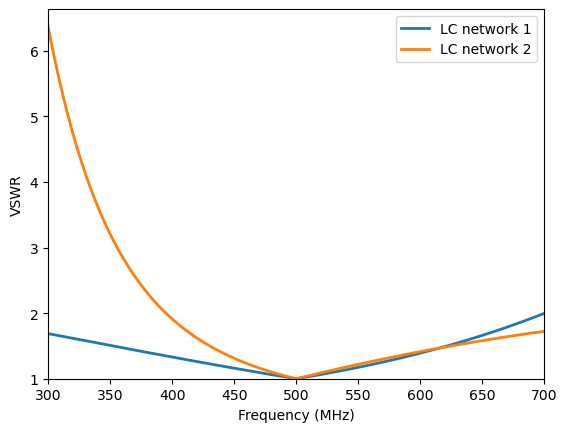

In [10]:
ntw1.plot_s_vswr(lw=2, label='LC network 1')
ntw2.plot_s_vswr(lw=2, label='LC network 2')
plt.ylim(bottom=1)

## Single-Stub Matching
Matching can be made with a piece of open-ended or shorted transmission line ( _stub_ ), connected either in parallel ( _shunt_ ) or in series (_trombone_). 

In the example below, a matching network is realized from a shorted transmission line of length ($\theta_{stub}$) connected in parallel, in association with a series transmission line ($\theta_{line}$). 

<img src="figures/Impedance_matching_stub1.svg">

Let's assume a load impedance $Z_L=60 - 80j$ connected to a 50 Ohm transmission line and let's match this load at 2 GHz: 

In [11]:
Z_L = 60 - 80j
Z_0 = 50
f_0_str = '2GHz'
# Frequency, wavenumber and transmission line media
freq = rf.Frequency(start=1, stop=3, npoints=301, unit='GHz')
beta = freq.w/rf.c
line = rf.DefinedGammaZ0(freq, gamma=1j*beta, z0=Z_0)

<img src="figures/Impedance_matching_stub1.svg">

In [12]:
def resulting_network(theta_line, theta_stub):
    """
    Return a loaded single stub matching network
    
    NB: theta_line and theta_stub lengths are in deg
    """
    delay_load = line.delay_load(rf.zl_2_Gamma0(Z_0, Z_L), theta_line)
    shunted_stub = line.shunt_delay_short(theta_stub)
    return shunted_stub ** delay_load

Optimize the matching network variables `theta_line` and `theta_stub` to match the resulting 1-port network ($|S|=0$)

In [19]:
from scipy.optimize import minimize

def optim_fun(x):
    return resulting_network(*x)[f_0_str].s_mag.ravel()

x0 = (50, 50)  # initial guess
bnd = (0, 180)  # boundaries 
res = minimize(optim_fun, x0, bounds=(bnd, bnd))
print(f'Optimum found for: theta_delay={res.x[0]:.1f} deg and theta_stub={res.x[1]:.1f} deg')

Optimum found for: theta_delay=39.8 deg and theta_stub=34.2 deg


In [ ]:
# Optimized network at f0
ntw = resulting_network(*res.x)
ntw.plot_s_vswr(lw=2)